### Getting started

In [1]:
import warnings

warnings.filterwarnings("ignore", message="Boolean inputs to the `inclusive` argument are deprecated infavour of `both` or `neither`.")

import numpy as np
import pandas as pd
import copy
import tqdm
import matplotlib.pyplot as plt

from collections import defaultdict

###
from jie import plot
from jie import aligner

###
# Multiprocessing
import multiprocessing.pool as mpp
from multiprocessing.pool import ThreadPool as Pool

# from https://stackoverflow.com/questions/57354700/starmap-combined-with-tqdm
# Author: Darkonaut (08/05/2019)

def istarmap(self, func, iterable, chunksize=1):
    """starmap-version of imap
    """
    self._check_running()
    if chunksize < 1:
        raise ValueError(
            "Chunksize must be 1+, not {0:n}".format(
                chunksize))

    task_batches = mpp.Pool._get_tasks(func, iterable, chunksize)
    result = mpp.IMapIterator(self)
    self._taskqueue.put(
        (
            self._guarded_task_generation(result._job,
                                          mpp.starmapstar,
                                          task_batches),
            result._set_length
        ))
    return (item for chunk in result for item in chunk)

mpp.Pool.istarmap = istarmap

### Download data
- Here, we will download seqFISH+ whole genome tracing of __mouse brain__ (Takei _et al., Science_ __374__, 586-596 (2021)).
<br></br>
- This is an <font color=red>__incredibly rich dataset__</font>, replete with...
    - `immunofluorescence imaging` of multiple histone modifications
    - super-resolved `DNA positions` imaged at 2 resolutions: 
        - `1 Mb` (spans whole-genome)
        - `25 kb` (spans ~ 1.5 Mb of each mouse chromosome)
    - Below, we only download the super-resolved DNA positions. 
<br></br> 
- `jie` assumes the candidate spots are already decoded (ie. a table of (`x`, `y`, `z`) spatial coordinates), instead of working with raw imaging data.

In [2]:
%%bash
dir='../data/mbrain'
if [[ ! -e $dir ]]; then
    mkdir ../data/mbrain
    wget -i ../data/mbrain_seqfish_urls.txt -P ../data/mbrain
fi

### Reference genome
- Next, we build a __reference table of genomic distances__ (`df_refgen`) that separate imaged probes.
    - This is critical for us to estimate an __expected spatial distance__, to which we compare the __observed spatial distance__ separating two imaged loci.
<br></br>
- Of note, this probe set was used much __earlier__ to image mouse embryonic stem cells (mESCs) (Takei _et al., Nature_ __590__, 344-350 (2021))
    - Theses coordinates below correspond to this earlier work's [Supplementary Table 1](https://static-content.springer.com/esm/art%3A10.1038%2Fs41586-020-03126-2/MediaObjects/41586_2020_3126_MOESM2_ESM.xlsx)

In [3]:
df = pd.read_csv("../data/TableS0_Mbcoords.csv")

# find genomic distance between each bin 
df_list = []

# for every chromosome
for chrom, group in df.groupby('Chrom'):
    
    # find genomic distance relative to preceding bin
    _df = copy.deepcopy(group)
    
    # sort by start
    _df.sort_values(by='Start', inplace = True)
    
    # record relative region ID (relative to chrom start site)
    _df['hyb'] = [i for i in range(_df.shape[0])]
    
    # calculate genomic distance relative to first starting position
    _df['delta'] = _df['Start'] - _df['Start'].iloc[0]
            
    df_list.append(_df)

# merge all dataframes
df_refgen = pd.concat(df_list)

In [4]:
df_refgen

,Region ID,Name,Channel,Chrom,Start,End,Chrom ID,hyb,delta
0,1,chr1-#1,1,chr1,3100000,3125000,1,0,0
1,2,chr1-#2,1,chr1,5000000,5025000,1,1,1900000
2,3,Atp6v1h,2,chr1,5057518,5082518,1,2,1957518
3,4,chr1-#3,1,chr1,7000000,7025000,1,3,3900000
4,5,chr1-#4,1,chr1,8800000,8825000,1,4,5700000
...,...,...,...,...,...,...,...,...,...
2455,2456,Gpm6b,2,chrX,166226411,166251411,20,115,160501411
2456,2457,chrX-#59,1,chrX,167225000,167250000,20,116,161500000
2457,2458,Tlr7,2,chrX,167318058,167343058,20,117,161593058
2458,2459,chrX-#60,1,chrX,169025000,169050000,20,118,163300000


### Candidate spatial coordinates
- We load decoded spatial coordinates of imaged genomic loci as a table (`df_seqfish`).

In [5]:
### HELPER FXN ###
def map_to_hyb(gene_name):
    return geneID_to_hyb[gene_name]

def map_to_chrom(gene_name):
    return geneID_to_chrom[gene_name]

def map_to_celltype(cluster):
    return celltype_dict[cluster]

# create lookup table for hyb
geneID_to_hyb = {name:hyb for name, hyb in zip(df_refgen['Name'], df_refgen['hyb'])}

# create lookup table for chrom
geneID_to_chrom = {name:chrom for name, chrom in zip(df_refgen['Name'], df_refgen['Chrom'])}

# assign cell type
celltype_dict = {1:'Pvalb',
                 2:'Vip',
                 3:'Ndnf',
                 4:'Sst',
                 5:'Astro',
                 6:'Micro',
                 7:'Endo',
                 8:'Oligo',
                 9:'Ex'}

# read in dataframe
df_seqfish = pd.read_csv("../data/mbrain/TableS7_brain_DNAseqFISH_1Mb_voxel_coordinates_2762cells.csv")

# assign cell type
df_seqfish['celltype'] = df_seqfish['cluster label'].apply(lambda x: map_to_celltype(x))

# record hyb
df_seqfish['hyb'] = df_seqfish['geneID'].apply(lambda x: map_to_hyb(x))

# record chrom
df_seqfish['chr'] = df_seqfish['geneID'].apply(lambda x: map_to_chrom(x))

# adjust Z resolution
df_seqfish['z'] = df_seqfish['z'] * 250/103

# add dummy localization error
df_seqfish['sig_z'] = [1, ] * df_seqfish.shape[0]
df_seqfish['sig_y'] = [1, ] * df_seqfish.shape[0]
df_seqfish['sig_x'] = [1, ] * df_seqfish.shape[0]

# rename columns
df_seqfish.rename(columns = {'z':'z_hat', 'y':'y_hat', 'x':'x_hat', 
                                'fov':'FOV', 'cellID':'cell', 'rep':'replicate'}, inplace = True)

- This can be subsetted into spatial coordinates by 
    - `celltype`
    - `chr`
    - `FOV`
    - `replicate`
    - `cell`
<br></br>    
- NB: A previous implementation provided a class `Cell` whose attributes store metadata and spatial coordinates.
    - This was difficult to subset (ie. find all `Cell` instances with `chr == 'chr7'` and `celltype == 'Astro'`). 
    - In this vignette, we store sets of coordinates in a DataFrame __`chr_pts`__ that allows quick subsetting. 
        - The column `data` is itself a list of `DataFrames`.
        - If you have a better database solution, __please submit an enhancement inquiry__ on Github!

In [6]:
# save results
chr_pts = {'replicate': {},
           'FOV': {},
           'cell': {},
           'finalcellID': {},
           'celltype': {},
           'chr': {},
           'XistID': {},
           'data': {}}

# group by celltype, chr, finalcellD
for i, (name, group) in enumerate(df_seqfish.groupby(by=['celltype', 'chr', 'finalcellID'])):
            
    # make copy
    _df_cell = copy.deepcopy(group)
    
    # drop columns
    _df_cell = _df_cell[['replicate', 'FOV', 'cell', 'finalcellID', 'celltype', 
                         'chr', 'hyb', 'geneID', 'XistID', 'cluster label',
                         'x_hat', 'y_hat', 'z_hat', 
                         'sig_x', 'sig_y', 'sig_z']]

    # sort by hyb_rnd
    _df_cell = _df_cell.sort_values(by=['hyb'])

    # reset index
    _df_cell.reset_index(inplace=True, drop = True)

    # save df
    chr_pts['replicate'][i] = _df_cell.iloc[0]['replicate']
    chr_pts['FOV'][i] = _df_cell.iloc[0]['FOV']
    chr_pts['cell'][i] = _df_cell.iloc[0]['cell']
    chr_pts['finalcellID'][i] = _df_cell.iloc[0]['finalcellID']
    chr_pts['celltype'][i] = _df_cell.iloc[0]['celltype']
    chr_pts['chr'][i] = _df_cell.iloc[0]['chr']
    chr_pts['XistID'][i] = False in np.isnan(_df_cell['XistID']).tolist()
    chr_pts['data'][i] = _df_cell
            
chr_pts = pd.DataFrame(chr_pts)

In [7]:
chr_pts

,replicate,FOV,cell,finalcellID,celltype,chr,XistID,data
0,2,0,5,3,Astro,chr1,False,replicate FOV cell finalcellID celltype ...
1,2,0,11,9,Astro,chr1,False,replicate FOV cell finalcellID celltype ...
2,2,0,24,20,Astro,chr1,False,replicate FOV cell finalcellID celltype...
3,2,0,36,29,Astro,chr1,False,replicate FOV cell finalcellID celltype...
4,2,0,43,34,Astro,chr1,False,replicate FOV cell finalcellID celltyp...
...,...,...,...,...,...,...,...,...
54276,4,6,248,2586,Vip,chrX,False,replicate FOV cell finalcellID celltype...
54277,4,7,50,2639,Vip,chrX,False,replicate FOV cell finalcellID celltype...
54278,4,7,70,2652,Vip,chrX,True,replicate FOV cell finalcellID celltyp...
54279,4,7,121,2686,Vip,chrX,False,replicate FOV cell finalcellID celltyp...


### Spatial genome alignment

- Say we wanted to find the median distance matrix of `chosen_chrom = 'chr19'` among `chosen_celltype = 'Ex'` neurons.
    - We use polymer fiber karyotyping (`jie.aligner.find_all_chr`) on sets of coordinates per cell, for a given chromosome.
        - `nm_per_bp` is the __distance parameter__ (a.k.a. conversion factor from genomic distance b.p. --> spatial distance nm)
        - `num_skip` is the __number of loci__ each node is allowed to look ahead, in case false positives need to be skipped.
        - `total_num_skip_frac` is the __fraction of total imaging sequence length__ considered sufficiently long to be designated as a chromatin fiber
        - `init_num_skip_frac` is the __fraction of total imaging sequence length__ the initial __source__ is allowed to look ahead. This parameter also allows nodes near the end of the chromosome to look ahead towards the __sink__.

In [8]:
import pickle

if __name__ == '__main__':
    
    chosen_chrom = 'chr19'
    chosen_celltype = 'Ex'    
    
    # grab candidate coordinates
    sel_chr_pts = chr_pts[(chr_pts['celltype'] == chosen_celltype) &
                          (chr_pts['chr'] == chosen_chrom)]['data'].tolist()
    
    # grab reference genome
    gene_dist = df_refgen[df_refgen['Chrom'] == chosen_chrom]['delta']
    
    # estimate bin size
    loci_starts = df_refgen[df_refgen['Chrom'] == chosen_chrom]['Start']
    intervals = [j-i for i, j in zip(loci_starts[:-1], loci_starts[1:])]
    bin_size = np.median(intervals)
    
    # read in parameters
    with open('../data/params/mbrain_Ex_2022_params_1mb_dipc.pkl', 'rb') as f:
        params = pickle.load(f)   
    nm_per_bp, tsf, isf = params[chosen_chrom]

    # set params
    nm_per_bps = [nm_per_bp,] * len(sel_chr_pts)
    num_skips = [15,] * len(sel_chr_pts) 
    bin_sizes = [bin_size,] * len(sel_chr_pts)
    total_num_skip_fracs = [tsf,] * len(sel_chr_pts)
    init_num_skip_fracs = [isf,] * len(sel_chr_pts)
    gene_dists = [gene_dist.values,] * len(sel_chr_pts)

    with Pool(1) as p:
        res = list(tqdm.tqdm(p.istarmap(aligner.find_all_chr, zip(sel_chr_pts, gene_dists, bin_sizes,
                                                                  nm_per_bps, num_skips, 
                                                                  total_num_skip_fracs,
                                                                  init_num_skip_fracs)), total = len(sel_chr_pts)))

  4%|███▎                                                                           | 76/1810 [00:19<07:06,  4.07it/s]Warning at src/paths/dijkstra.c:441 : Couldn't reach some vertices
Warning at src/paths/dijkstra.c:441 : Couldn't reach some vertices
 16%|████████████▎                                                                 | 285/1810 [01:08<06:37,  3.84it/s]Warning at src/paths/dijkstra.c:441 : Couldn't reach some vertices


 19%|██████████████▊                                                               | 345/1810 [01:20<06:00,  4.06it/s]Warning at src/paths/dijkstra.c:441 : Couldn't reach some vertices
Warning at src/paths/dijkstra.c:441 : Couldn't reach some vertices
 29%|██████████████████████▎                                                       | 517/1810 [02:04<02:07, 10.18it/s]Warning at src/paths/dijkstra.c:441 : Couldn't reach some vertices


 34%|██████████████████████████▌                                                   | 615/1810 [02:38<02:34,  7.74it/s]Warning at src/paths/dijkstra.c:441 : Couldn't reach some vertices
Warning at src/paths/dijkstra.c:441 : Couldn't reach some vertices
 38%|█████████████████████████████▍                                                | 684/1810 [02:59<06:25,  2.92it/s]Warning at src/paths/dijkstra.c:441 : Couldn't reach some vertices
Warning at src/paths/dijkstra.c:441 : Couldn't reach some vertices
 46%|████████████████████████████████████▏                                         | 841/1810 [03:43<04:52,  3.32it/s]Warning at src/paths/dijkstra.c:441 : Couldn't reach some vertices


 64%|█████████████████████████████████████████████████                            | 1154/1810 [05:31<03:15,  3.36it/s]Warning at src/paths/dijkstra.c:441 : Couldn't reach some vertices
Warning at src/paths/dijkstra.c:441 : Couldn't reach some vertices
 65%|█████████████████████████████████████████████████▊                           | 1172/1810 [05:37<03:34,  2.97it/s]Warning at src/paths/dijkstra.c:441 : Couldn't reach some vertices


 72%|███████████████████████████████████████████████████████▋                     | 1309/1810 [06:27<02:30,  3.33it/s]Warning at src/paths/dijkstra.c:441 : Couldn't reach some vertices
Warning at src/paths/dijkstra.c:441 : Couldn't reach some vertices
 82%|███████████████████████████████████████████████████████████████▏             | 1484/1810 [07:29<01:48,  2.99it/s]Warning at src/paths/dijkstra.c:441 : Couldn't reach some vertices


 90%|█████████████████████████████████████████████████████████████████████        | 1623/1810 [08:22<01:18,  2.39it/s]Warning at src/paths/dijkstra.c:441 : Couldn't reach some vertices
Warning at src/paths/dijkstra.c:441 : Couldn't reach some vertices
 92%|██████████████████████████████████████████████████████████████████████▌      | 1658/1810 [08:37<01:07,  2.26it/s]Warning at src/paths/dijkstra.c:441 : Couldn't reach some vertices
Warning at src/paths/dijkstra.c:441 : Couldn't reach some vertices
100%|█████████████████████████████████████████████████████████████████████████████| 1810/1810 [09:31<00:00,  3.17it/s]


- The result is a `list` of `list`s, where each sublist contains DataFrames of putative chromatin fibers. 
- Empty lists denote no likely fiber found; the length of the list is used to assign a __karyotype__.

In [9]:
print(len(res[0]), len(res[5]), len(res[55]))

0 2 3


- We can flatten all putative chromatin fibers and calculate the median distance matrix.

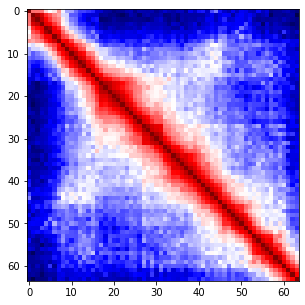

In [10]:
# flatten
res_flat = [fiber for cell_res in res for fiber in cell_res]
med_dist_mat = plot.calc_med_dist_mat(res_flat, len(gene_dist))

# plot
fig, axs = plt.subplots(figsize = (5, 5))
axs.imshow(med_dist_mat, cmap = 'seismic_r')

- We can also inspect structural heterogeneity at the single cell level:

/tmp/ipykernel_1358551/170347527.py:5: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. This has been deprecated since 3.3 and in 3.6, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = mpl.cm.get_cmap("seismic_r").copy()
  cmap.set_bad("gray")


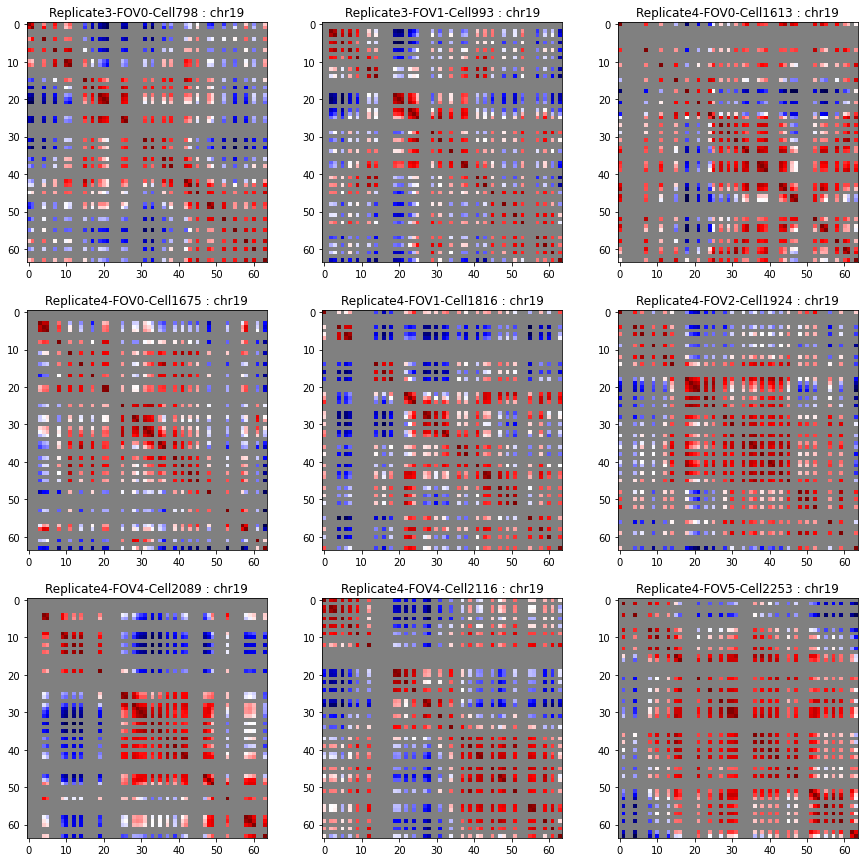

In [16]:
import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning)

cmap = plt.get_cmap("seismic_r")
cmap.set_bad("gray")

fig, axs = plt.subplots(3, 3, figsize = (15, 15))
example_idxs = [556, 729, 1259, 1355, 1498, 1629, 1751, 1787, 1937]
for idx, ax in zip(example_idxs, axs.flatten()):
    
    # median distance matrix for single fiber
    mat = plot.calc_med_dist_mat([res_flat[idx]], len(gene_dist))
    
    # grab metadata
    rep, fov, cellid = res_flat[idx].iloc[0]['replicate'], res_flat[idx].iloc[0]['FOV'], res_flat[idx].iloc[0]['finalcellID']
    
    # show
    ax.imshow(mat, cmap = cmap)
    ax.set_title("Replicate{0}-FOV{1}-Cell{2} : {3}".format(rep, fov, cellid, chosen_chrom))

- We can compare to __proximity-ligation sequencing__ to inspect the spatial genome aligned structures.
    - To compare _cell-type specific_ single-cell mouse brain 3D genome, we look to __Dip-C__ data ([GSE146397](https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSE146397))
    - We extracted these contact frequencies using [Straw](https://github.com/aidenlab/straw) at 1 Mb resolution.
    <br></br>
    - Extracted `numpy` matrices of contact frequencies are provided in `jie/data/npy/dipc`)
        - Of note, some of the imaged loci lie in the same ~ 1 Mb bin. Still others are not imaged at all.
            - In the case of "doubly" imaged loci, we keep the contacts corresponding to the earliest bin w.r.t. the starting locus of the chromosome.
            - In the case of an unimaged loci, we omit the binned contacts altogether.
            - Vice versa, if a loci is imaged but too few reads mapped to the corresponding bin, this is dropped from the spatial distance matrix
            - These dropped bin indeces are saved under `jie/data/npy/dipc/{celltype}/*_droppedidx.npy`.

/tmp/ipykernel_1358551/1163564718.py:39: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. This has been deprecated since 3.3 and in 3.6, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = mpl.cm.get_cmap("seismic_r").copy()
  cmap_dist.set_bad(alpha=0)
/tmp/ipykernel_1358551/1163564718.py:40: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. This has been deprecated since 3.3 and in 3.6, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = mpl.cm.get_cmap("Reds").copy()
  cmap_hic.set_bad(alpha=0)


Text(0.5, 1.1, 'Ex - 1 Mb')

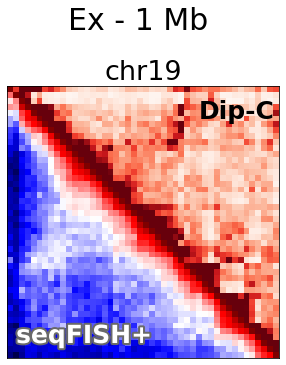

In [17]:
import matplotlib.patheffects as pe
from numpy.ma import masked_array

# load dipc matrix
hic_mat = np.load("../data/npy/dipc/{0}/{0}_seqfish_{1}_1Mb_hic.npy".format(chosen_celltype, chosen_chrom))
dropped = np.load("../data/npy/dipc/{0}/{0}_seqfish_{1}_1Mb_hic_droppedidx.npy".format(chosen_celltype, chosen_chrom))

# reorder distance matrix to match hic contact matrix shape
remap_hyb = {}
counter = 0
for hyb in range(len(gene_dist)):
    if hyb not in dropped:
        remap_hyb[hyb] = counter
        counter +=1

# NB: One bin not imaged, drop
chroms_flatten = [chrom[chrom['geneID'] != 'Mid1'] for chrom in res_flat]

# drop mismatched bins from spatial coordinates
chroms_flattened_dropped = []
for chrom_pts in chroms_flatten:
    _df = copy.deepcopy(chrom_pts)
    _df = _df[~_df['hyb'].isin(dropped)]
    _df['Old hyb'] = _df['hyb']
    _df['hyb'] = [remap_hyb[hyb] for hyb in _df['Old hyb']]
    chroms_flattened_dropped.append(_df)

# calculate spatial distance matrix
dist_mat = plot.calc_med_dist_mat(chroms_flattened_dropped, hic_mat.shape[0])

# make hic-dist split matrix
split_up = masked_array(hic_mat, np.logical_not(np.triu(np.ones(hic_mat.shape[0])) > 0))
split_low = masked_array(dist_mat, np.logical_not(np.tril(np.ones(hic_mat.shape[0])) > 0))

### PLOT ###
fig, axs = plt.subplots(figsize = (5, 5))
cmap_dist = plt.get_cmap("seismic_r")
cmap_hic = plt.get_cmap("Reds")
cmap_dist.set_bad(alpha=0)
cmap_hic.set_bad(alpha=0)
axs.imshow(np.clip(split_up, 0, 400), cmap = cmap_hic)
axs.imshow(np.clip(split_low*100, 0, 3000), cmap = cmap_dist)
axs.set_title("{}".format(chosen_chrom), fontsize=27)

# annotate
axs.text(32, 5, "Dip-C", color = "black", fontsize = 25, fontweight='bold')
axs.text(1, 43, "seqFISH+", color="white", fontsize = 25, fontweight='bold',
         path_effects=[pe.withStroke(linewidth=4, foreground="dimgray")])

# set plot parameters
axs.tick_params(axis='both',      
                which='both',     
                bottom=False,     
                top=False,        
                left = False,
                right = False,
                labelleft = False,
                labelbottom=False) 

# add title
plt.suptitle("{} - 1 Mb".format(chosen_celltype), fontsize = 30, y=1.1)

- We can plot the Spearman correlation between the contact frequency and spatial genome aligner determined distances.

Text(0.5, 1.1, 'Ex - 1 Mb')

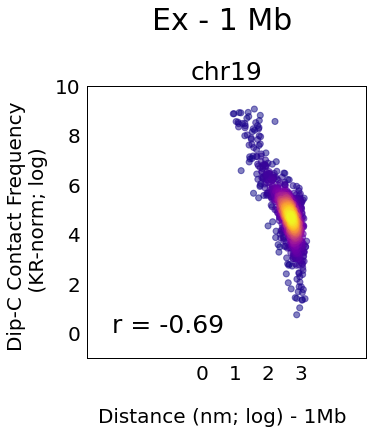

In [18]:
from scipy.stats import spearmanr, gaussian_kde

# calculate spearman corr
corr, p = spearmanr(hic_mat.flatten(), dist_mat.flatten(), nan_policy = 'omit')

# KDE
x = np.log(dist_mat.flatten())
y = np.log(hic_mat.flatten())
drop_indeces = set(np.where(np.isinf(x))[0]).union(np.where(np.isinf(y))[0]) # remove inf
nan_indeces = set(np.where(np.isnan(x))[0]).union(np.where(np.isnan(y))[0]) # remove nans
drop_indeces = drop_indeces.union(nan_indeces)

x = [x[i] for i in range(len(x)) if i not in drop_indeces]
y = [y[i] for i in range(len(y)) if i not in drop_indeces]

xy = np.vstack([x, y])
z = gaussian_kde(xy)(xy)
density = z.argsort()

# plot
fig, axs = plt.subplots(figsize = (5, 5))
axs.scatter([x[i] for i in density],
                                    [y[i] for i in density],
                                    c=[z[i] for i in density],
                                    cmap = 'plasma',
                                    alpha = 0.3)

axs.set_title("{}".format(chosen_chrom), fontsize=25)
axs.set_xlim(-3.5, 5)
axs.set_ylim(-1, 10)
axs.patch.set_edgecolor('black')
axs.patch.set_linewidth('1')
axs.annotate('r = {0:.2g}'.format(corr), xy=(-2.75, -0), fontsize = 25)

# set plot parameters
axs.tick_params(axis='both',      
                which='major',     
                bottom=False,     
                top=False,        
                left = False,
                right = False,
                labelleft = True,
                labelbottom=True,
                labelsize = 20) 

fig.text(0.5, -0.04, 'Distance (nm; log) - 1Mb', 
         ha="center", va="center", fontsize = 20 )
fig.text(-0.04, 0.5, 'Dip-C Contact Frequency \n (KR-norm; log)', 
         ha="center", va="center", rotation=90, fontsize = 20)
plt.xticks(np.arange(0, 4, 1.0))
plt.suptitle("{} - 1 Mb".format(chosen_celltype), fontsize = 30, y = 1.1)